<a href="https://colab.research.google.com/github/AbdullahMoustafa2010/rdpwrap/blob/master/Jaws_Segmentation_Task_Abdalla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Jaws Segmentation Task

Hello, You're tasked with building a neural network using pytorch which segments upper (Maxilla) and lower(Mandible) jaws in a DICOM file

The Dataset is provided as 2D slices from all 3 orthogonal points of view Axial, Coronal, and Sagittal, if you're not familiar with what a DICOM is, you're expected to read online about it

Duration: 1 Week

Deliverables: This notebook (which should contain your solution), and any other files (like saved weights) in a **zip** file, and you mail this **zip** file to us

In [ ]:
# GPU Test
!nvidia-smi
import torch
torch.cuda.is_available()

Wed May 25 22:31:12 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   39C    P8    11W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

True

In [ ]:
! pip install --user torch torchvision matplotlib numpy progressbar

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for progressbar: filename=progressbar-2.5-py3-none-any.whl size=12082 sha256=7ccb222bdd6687026e062879cc165018a05e95275b4cd2ce211fc92b903aafe1
  Stored in directory: /root/.cache/pip/wheels/f0/fd/1f/3e35ed57e94cd8ced38dd46771f1f0f94f65fec548659ed855
Successfully built progressbar


In [ ]:
import urllib.request
import zipfile
import os
import progressbar
from math import ceil
import torch
import gzip
import numpy as np
import glob
import matplotlib.pyplot as plt
from torchvision import transforms
#Added Libraries
import torch.nn as nn
import torch.nn.functional as F
import torchvision
#import torchvision.transforms.functional as TF

from tqdm import tqdm
#from scipy import ndimage

In [ ]:
LOCAL_DATASET_PATH = 'dataset'
BATCH_SIZE = 16
#Some Added Param
NUM_EPOCHS = 10
#DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
LEARNING_RATE = 1e-4  # Trial and error
IMAGE_HEIGHT = 128
IMAGE_WIDTH = 128
Start=True
 


AXIAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip'
AXIAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip'
CORONAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip'
CORONAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip'
SAGITTAL_TRAINING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip'
SAGITTAL_TESTING_DATASET = 'https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip'

## Downloading Dataset

In this part we download the publicly available dataset, you can skip it if you already have it, it should be 5.6 Gb worth of data

In [ ]:
download_progress_bar = None
def show_progress(block_num, block_size, total_size):
    global download_progress_bar
    if download_progress_bar is None:
        download_progress_bar = progressbar.ProgressBar(maxval=total_size)
        download_progress_bar.start()

    downloaded = block_num * block_size
    if downloaded < total_size:
        download_progress_bar.update(downloaded)
    else:
        download_progress_bar.finish()
        download_progress_bar = None

def download_file(url, disk_path):
    print(f'downloading {url}')
    filename, _ = urllib.request.urlretrieve(url, reporthook=show_progress)
    os.makedirs(disk_path)
    with zipfile.ZipFile(filename, 'r') as zip:
        zip.extractall(disk_path)

def download_data(to=LOCAL_DATASET_PATH):
    download_file(AXIAL_TRAINING_DATASET, os.path.join(to, 'axial', 'train'))
    download_file(AXIAL_TESTING_DATASET, os.path.join(to, 'axial', 'test'))
    download_file(CORONAL_TRAINING_DATASET, os.path.join(to, 'coronal', 'train'))
    download_file(CORONAL_TESTING_DATASET, os.path.join(to, 'coronal', 'test'))
    download_file(SAGITTAL_TRAINING_DATASET, os.path.join(to, 'sagittal', 'train'))
    download_file(SAGITTAL_TESTING_DATASET, os.path.join(to, 'sagittal', 'test'))

download_data()

downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/train.zip


100% (1687658425 of 1687658425) |########| Elapsed Time: 0:00:45 Time:  0:00:45


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/axial/test.zip


100% (345779382 of 345779382) |##########| Elapsed Time: 0:00:10 Time:  0:00:10


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/train.zip


100% (1688318975 of 1688318975) |########| Elapsed Time: 0:00:47 Time:  0:00:47


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/coronal/test.zip


100% (347373983 of 347373983) |##########| Elapsed Time: 0:00:10 Time:  0:00:10


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/train.zip


100% (1686885165 of 1686885165) |########| Elapsed Time: 0:00:47 Time:  0:00:47


downloading https://cvml-datasets.s3.eu-west-3.amazonaws.com/jaws-segmentation/v1/public/2d/sagittal/test.zip


100% (346507429 of 346507429) |##########| Elapsed Time: 0:00:10 Time:  0:00:10


## Explore The Dataset

In this section you should explore/plot the dataset and get familiar with it, we are nice enough to write a dataset loader for you and we did some initial visualization for you

In [ ]:
class JawsDataset(torch.utils.data.Dataset):
	def __init__(self, dicom_file_list, transforms):
		self.dicom_file_list = dicom_file_list
		self.transforms = transforms

	def __len__(self):
		return len(self.dicom_file_list)

	def __getitem__(self, idx):
		dicom_path = self.dicom_file_list[idx]
		label_path = dicom_path.replace('.dicom.npy.gz', '.label.npy.gz')
		dicom_file = gzip.GzipFile(dicom_path, 'rb')
		dicom = np.load(dicom_file)
		label_file = gzip.GzipFile(label_path, 'rb')
		label = np.load(label_file)
		return self.transforms(dicom), self.transforms(label)

def axial_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/axial/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def coronal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/coronal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def sagittal_dataset_train(transforms, validation_ratio = 0.1):
	files = glob.glob('dataset/sagittal/train/**/*.dicom.npy.gz')
	assert len(files) > 0
	assert len(files) > 0
	validation_files_count = ceil(len(files) * validation_ratio)

	return (JawsDataset(files[validation_files_count:], transforms),
			JawsDataset(files[:validation_files_count], transforms))

def axial_dataset_test(transforms):
	files = glob.glob('dataset/axial/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def coronal_dataset_test(transforms):
	files = glob.glob('dataset/coronal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)

def sagittal_dataset_test(transforms):
	files = glob.glob('dataset/sagittal/test/**/*.dicom.npy.gz')
	assert len(files) > 0
	return JawsDataset(files, transforms)


In [ ]:
dataset_transforms = transforms.Compose([transforms.ToTensor(), transforms.Resize((128, 128))])



In [ ]:
axial_train_dataset, axial_validatiaon_dataset = axial_dataset_train(dataset_transforms)
coronal_train_dataset, coronal_validation_dataset = coronal_dataset_train(dataset_transforms)
sagittal_train_dataset, sagittal_validation_dataset = sagittal_dataset_train(dataset_transforms)
print(f'axial training dataset: {len(axial_train_dataset)} slice')
print(f'axial Validation dataset: {len(axial_validatiaon_dataset)} slice')

print(f'coronal training dataset: {len(coronal_train_dataset)} slice')
print(f'coronal Validation dataset: {len(coronal_validation_dataset)} slice')

print(f'sagittal training dataset: {len(sagittal_train_dataset)} slice')
print(f'sagittal Validation dataset: {len(sagittal_validation_dataset)} slice')


axial_train_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_train_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_train_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)


# prepare the loader for the validation Dataset
axial_validation_loader = torch.utils.data.DataLoader(axial_validatiaon_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_validation_loader = torch.utils.data.DataLoader(coronal_validation_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_validation_loader = torch.utils.data.DataLoader(sagittal_validation_dataset, shuffle=True, batch_size=BATCH_SIZE)

axial training dataset: 5043 slice
axial Validation dataset: 561 slice
coronal training dataset: 7277 slice
coronal Validation dataset: 809 slice
sagittal training dataset: 7277 slice
sagittal Validation dataset: 809 slice


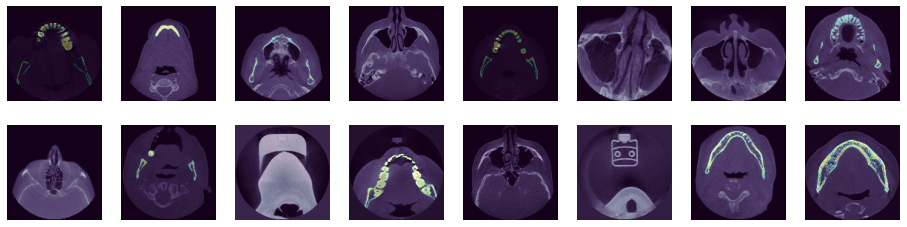

In [ ]:
axial_data_iter = iter(axial_train_loader)
images, labels = axial_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)
#print(images[7].numpy())
#print(len(labels))
#print(next(axial_data_iter) )
  #print(f'Label: {labels[index]}')

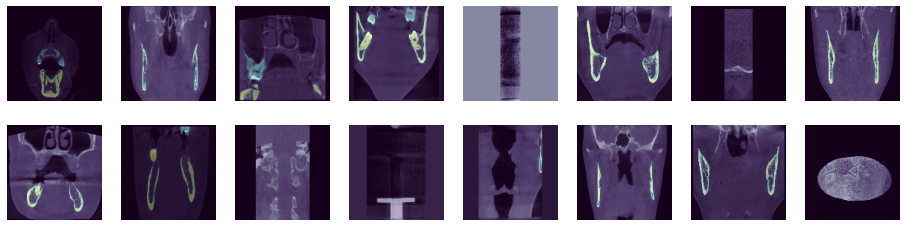

In [ ]:
coronal_data_iter = iter(coronal_train_loader)
images, labels = coronal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

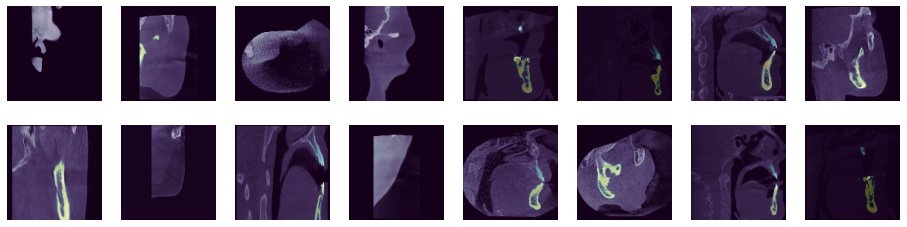

In [ ]:
sagittal_data_iter = iter(sagittal_train_loader)
images, labels = sagittal_data_iter.next()
plt.figure(figsize=(16, 4))
for index in range(0, min(16, len(images))):
	plt.subplot(2, 8, index + 1)
	plt.axis('off')
	plt.imshow(images[index].numpy().squeeze(), cmap='bone')
	plt.imshow(labels[index].numpy().squeeze(), alpha=0.3)

## Training

Now that you have downloaded the dataset and inspected it for a bit, you should train your model here, you can train a single model which works with all views (axial, sagittal, coronal), or you can train a model each, it's up to you

In [ ]:
# for the next sections during the training I made use of the code of:
# https://www.kaggle.com/code/youssefelkilany/jaws-segmentation?scriptVersionId=89787508

# Needed functions that will be used:
def save_checkpoint(state, filename):
    print("=> Saving checkpoint")
    torch.save(state, filename)

def load_checkpoint(checkpoint, model):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])

def tversky_index(inputs, targets, smooth=1, alpha=1, beta=1):
    inputs = torch.sigmoid(inputs)       

    #flatten label and prediction tensors
    inputs = inputs.view(-1)
    targets = targets.view(-1)

    #True Positives, False Positives & False Negatives
    TP = (inputs * targets).sum()    
    FP = ((1-targets) * inputs).sum()
    FN = (targets * (1-inputs)).sum()

    Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)  
    return 1 - Tversky    

# to check the accuracy we used Amos Tversky (an asymmetric similarity measure on sets that compares a variant to a prototype.)
def check_accuracy(loader, model, device="cuda"):
    dice_score = 0
    tversky_score = 0
    model.eval()

    with torch.no_grad():
        for x, y in tqdm(loader):
            x = x.to(device)
            y = y.to(device)
            preds = torch.sigmoid(model(x))
            t = .5 # a threshold for pixels predicted  to seperate between the object 1, and the background 0
            preds = (preds > t).float()
            tversky_score += tversky_index(y, preds)
            dice_score += (2 * (preds * y).sum()) / ((preds + y).sum() + 1e-8)

    print(f"Tversky score: {tversky_score/len(loader)}")
    print(f"Dice score: {dice_score/len(loader)}")
    model.train()

def save_predictions_as_imgs(loader, model, folder="saved_images/", device="cuda"):
    model.eval()
    for idx, (x, y) in enumerate(loader):
        x = x.to(device=device)
        with torch.no_grad():
            preds = torch.sigmoid(model(x))
            preds = (preds > 0.5).float()
        torchvision.utils.save_image(preds, f"{folder}/pred_{idx}.png")
        torchvision.utils.save_image(y.unsqueeze(1), f"{folder}{idx}.png")

    model.train()

# Computing the Tverskyloss and then convert it into similarity
class TverskyLoss(nn.Module):
    def __init__(self):
        super(TverskyLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1, alpha=1, beta=1):
        
        # We will use UNet, since its final layer does not include sigmoid so we will add it.
        inputs = torch.sigmoid(inputs)
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        #True Positives, False Positives & False Negatives
        TP = (inputs * targets).sum()
        FP = (inputs * (1 - targets)).sum()
        FN = (targets * (1 - inputs)).sum()
       # Tverskyloss equation using True Positives, False Positives & False Negatives
        Tversky = (TP + smooth) / (TP + alpha*FP + beta*FN + smooth)
        
        return 1 - Tversky
    

In [ ]:
# Our Model Formation

class Network(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(Network, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.conv(x)

class UNET(nn.Module):
    def __init__(
            self, in_channels=3, out_channels=1, features=[64, 128, 256, 512],
    ):
        super(UNET, self).__init__()
        self.ups = nn.ModuleList()
        self.downs = nn.ModuleList()
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Down part of UNET
        for feature in features:
            self.downs.append(Network(in_channels, feature))
            in_channels = feature

        # Up part of UNET
        for feature in reversed(features):
            self.ups.append(
                nn.ConvTranspose2d(
                    feature*2, feature, kernel_size=2, stride=2,
                )
            )
            self.ups.append(Network(feature*2, feature))

        self.bottleneck = Network(features[-1], features[-1]*2)
        self.final_conv = nn.Conv2d(features[0], out_channels, kernel_size=1)

    def forward(self, x):
        skip_connections = []

        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        x = self.bottleneck(x)
        skip_connections = skip_connections[::-1]

        for idx in range(0, len(self.ups), 2):
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]

            if x.shape != skip_connection.shape:
                x = torchvision.transforms.functional.resize(x, size=skip_connection.shape[2:])

            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

        return self.final_conv(x)


#--------------------------
# Show  the network structure
#---------------------------
#net = Network()
#print(Network())     

#-------------------
# Show the net Param
#-------------------
#params = list(net.parameters())
#print(len(params))
#print(params[0].size())  



# Saving the model to the current path
#torch.save(net, 'dataset')




### Training Part

In [ ]:
train_loaders = {
    'axial': axial_train_loader,
    'coronal': coronal_train_loader,
    'sagittal': sagittal_train_loader
}

val_loaders = {
    'axial': axial_validation_loader,
    'coronal': coronal_validation_loader,
    'sagittal': sagittal_validation_loader
}

def train_fn(loader, model, optimizer, loss_fn, scaler):
    loop = tqdm(loader)

    for batch_idx, (images, labels) in enumerate(loop):
        images = images.to(device="cuda")
        labels = labels.to(device="cuda")
        
        # forward
        #with torch.cuda.amp.autocast():
        with torch.cuda.amp.autocast():
            predictions = model(images)
            loss = loss_fn(predictions, labels)

        # backward
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        # update tqdm loop
        loop.set_postfix(loss=loss.item())

def train_model_2d(plane):
    model = UNET(in_channels=1, out_channels=1).to("cuda")

    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE) 
    def chkpntfile(batch=-1):
        # chkpts are either in range 0-9 or padded with 0 at beginning
        #if batch != -1:
            return f'TestingPath/{plane}/my_checkpoint_{batch}.pth.tar'
        
        #return sorted(glob.glob(f'TestingPath/{plane}/my_checkpoint_*.pth.tar'))[-1]
    
    if Start:
        try:
            load_checkpoint(torch.load(chkpntfile()), model)
        except Exception:
            print(f'No chkpnt file found for {plane} model')
            print(f'create a new {plane} model')
    
    train_loader = train_loaders[plane]
    val_loader = val_loaders[plane]
    
    loss_fn = TverskyLoss() 
    
    check_accuracy(val_loader, model, device="cuda")
    #scaler= torch.cpu.amp.GradScaler()
    scaler = torch.cuda.amp.GradScaler()
    
    for epoch in range(NUM_EPOCHS):
        train_fn(train_loader, model, optimizer, loss_fn, scaler)
        
        # save model
      #  checkpoint = {
       #     'state_dict': model.state_dict(),
        #    'optimizer': optimizer.state_dict(),
       # }
       # save_checkpoint(checkpoint, chkpntfile(epoch))
        
        # check accuracy
        check_accuracy(val_loader, model, device="cuda")
        
#         # print some examples to a folder
#         save_predictions_as_imgs(
#             axial_validation_loader, model, folder=f"{LOCAL_OTUPUT_PATH}/saved_images/", device=DEVICE
#         )
    return model

In [ ]:
# Model for the Axial plane:
axial_model = train_model_2d('axial')

No chkpnt file found for axial model
create a new axial model


100%|██████████| 36/36 [00:04<00:00,  7.31it/s]


Tversky score: 0.9786988496780396
Dice score: 0.01990259811282158


100%|██████████| 36/36 [00:04<00:00,  7.26it/s]


Tversky score: 0.9548733234405518
Dice score: 1.1614261865615845


100%|██████████| 36/36 [00:04<00:00,  7.34it/s]


Tversky score: 0.9490059018135071
Dice score: 1.1105811595916748


100%|██████████| 36/36 [00:04<00:00,  7.34it/s]


Tversky score: 0.9578535556793213
Dice score: 1.199942708015442


100%|██████████| 36/36 [00:04<00:00,  7.25it/s]


Tversky score: 0.9621666073799133
Dice score: 1.1473984718322754


100%|██████████| 36/36 [00:04<00:00,  7.36it/s]


Tversky score: 0.959703266620636
Dice score: 1.1938215494155884


100%|██████████| 36/36 [00:04<00:00,  7.43it/s]


Tversky score: 0.9587210416793823
Dice score: 1.1951552629470825


100%|██████████| 36/36 [00:06<00:00,  6.00it/s]


Tversky score: 0.9584224820137024
Dice score: 1.2065927982330322


100%|██████████| 36/36 [00:04<00:00,  7.38it/s]


Tversky score: 0.9581534266471863
Dice score: 1.2062597274780273


100%|██████████| 36/36 [00:04<00:00,  7.46it/s]


Tversky score: 0.957580029964447
Dice score: 1.1957958936691284


100%|██████████| 36/36 [00:04<00:00,  7.41it/s]

Tversky score: 0.9572092890739441
Dice score: 1.1944611072540283


In [ ]:
# Saving the trained models weights:

#1- Save axial model:
torch.save(axial_model.state_dict(), '/content/Model_weights/axial_model_weights')

In [ ]:
# Model for the Sagittal plane:
sagittal_model = train_model_2d('sagittal')

No chkpnt file found for sagittal model
create a new sagittal model


100%|██████████| 51/51 [00:05<00:00, 10.12it/s]


Tversky score: 0.5533223152160645
Dice score: 0.09637351334095001


100%|██████████| 51/51 [00:04<00:00, 10.58it/s]


Tversky score: 0.9548241496086121
Dice score: 1.1102467775344849


100%|██████████| 51/51 [00:04<00:00, 11.06it/s]


Tversky score: 0.9630750417709351
Dice score: 1.2287156581878662


100%|██████████| 51/51 [00:04<00:00, 10.71it/s]


Tversky score: 0.9634172916412354
Dice score: 1.2269688844680786


100%|██████████| 51/51 [00:04<00:00, 11.15it/s]


Tversky score: 0.9647329449653625
Dice score: 1.2286022901535034


100%|██████████| 51/51 [00:04<00:00, 11.13it/s]


Tversky score: 0.9641636610031128
Dice score: 1.230445384979248


100%|██████████| 51/51 [00:04<00:00, 11.17it/s]


Tversky score: 0.9626426100730896
Dice score: 1.2310134172439575


100%|██████████| 51/51 [00:04<00:00, 11.23it/s]


Tversky score: 0.9638845920562744
Dice score: 1.2288453578948975


100%|██████████| 51/51 [00:04<00:00, 11.22it/s]


Tversky score: 0.9634178280830383
Dice score: 1.2255275249481201


100%|██████████| 51/51 [00:04<00:00, 11.22it/s]


Tversky score: 0.9639556407928467
Dice score: 1.230409026145935


100%|██████████| 51/51 [00:04<00:00, 11.19it/s]

Tversky score: 0.9676366448402405
Dice score: 1.1728571653366089


In [ ]:
#2- Save sagittal model:
torch.save(sagittal_model.state_dict(), '/content/Model_weights/sagittal_model_weights')

In [ ]:
# Model for the coronal plane:
coronal_model = train_model_2d('coronal')

No chkpnt file found for coronal model
create a new coronal model


100%|██████████| 51/51 [00:05<00:00,  9.34it/s]


Tversky score: 0.5833273530006409
Dice score: 0.018772253766655922


100%|██████████| 51/51 [00:04<00:00, 11.04it/s]


Tversky score: 0.9582498669624329
Dice score: 1.142356038093567


100%|██████████| 51/51 [00:04<00:00, 11.14it/s]


Tversky score: 0.9650260210037231
Dice score: 1.1836397647857666


100%|██████████| 51/51 [00:04<00:00, 11.28it/s]


Tversky score: 0.961410641670227
Dice score: 1.1953136920928955


100%|██████████| 51/51 [00:04<00:00, 11.24it/s]


Tversky score: 0.9657014012336731
Dice score: 1.1919881105422974


100%|██████████| 51/51 [00:04<00:00, 11.05it/s]


Tversky score: 0.9629456996917725
Dice score: 1.2256977558135986


100%|██████████| 51/51 [00:04<00:00, 11.39it/s]


Tversky score: 0.9624967575073242
Dice score: 1.2127963304519653


100%|██████████| 51/51 [00:04<00:00, 11.02it/s]


Tversky score: 0.9626827836036682
Dice score: 1.2172247171401978


100%|██████████| 51/51 [00:04<00:00, 10.49it/s]


Tversky score: 0.9639965295791626
Dice score: 1.2269800901412964


100%|██████████| 51/51 [00:04<00:00, 11.31it/s]


Tversky score: 0.9632479548454285
Dice score: 1.2258268594741821


100%|██████████| 51/51 [00:04<00:00, 11.43it/s]

Tversky score: 0.962605357170105
Dice score: 1.2262465953826904


In [ ]:
#3- Save coronal model:
torch.save(coronal_model.state_dict(), '/content/Model_weights/coronal_model_weights')

In [ ]:
# Grouping the models together to help in the testing.
models = {
    'axial': axial_model,
    'sagittal': sagittal_model,
    'coronal': coronal_model,
}

## Testing

Now you should run your trained model on the test dataset available below and report your results

In [ ]:
axial_test_dataset = axial_dataset_test(dataset_transforms)
coronal_test_dataset = coronal_dataset_test(dataset_transforms)
sagittal_test_dataset = sagittal_dataset_test(dataset_transforms)
print(f'axial testing dataset: {len(axial_test_dataset)} slice')
print(f'coronal testing dataset: {len(coronal_test_dataset)} slice')
print(f'sagittal testing dataset: {len(sagittal_test_dataset)} slice')

axial_test_loader = torch.utils.data.DataLoader(axial_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
coronal_test_loader = torch.utils.data.DataLoader(coronal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)
sagittal_test_loader = torch.utils.data.DataLoader(sagittal_train_dataset, shuffle=True, batch_size=BATCH_SIZE)

test_loaders = {
    'axial': axial_test_loader,
    'coronal': coronal_test_loader,
    'sagittal': sagittal_test_loader
}

axial testing dataset: 1450 slice
coronal testing dataset: 2348 slice
sagittal testing dataset: 2448 slice


In [ ]:
#Testing the trained Model on the test data and get the accuracy results
for plane in ['axial', 'coronal', 'sagittal']:
    check_accuracy(test_loaders[plane], models[plane], device="cuda")

100%|██████████| 316/316 [00:58<00:00,  5.37it/s]


Tversky score: 0.958355724811554
Dice score: 1.193016529083252


100%|██████████| 455/455 [01:00<00:00,  7.50it/s]


Tversky score: 0.9597984552383423
Dice score: 1.2127608060836792


100%|██████████| 455/455 [01:01<00:00,  7.36it/s]

Tversky score: 0.9618483185768127
Dice score: 1.200215458869934
